In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [38]:
# Load datasets of palbociclib CRISRP screen
gene_summary = pd.read_table("./input_data/CRISPR_screen/palbo_vs_dmso_control_normalized.gene_summary.txt", sep='\t')
normalized_counts = pd.read_table("./input_data/CRISPR_screen/palbo_vs_dmso_control_normalized.normalized.txt", sep='\t')

In [37]:
gene_summary.columns


Index(['id', 'num', 'neg|score', 'neg|p-value', 'neg|fdr', 'neg|rank',
       'neg|goodsgrna', 'neg|lfc', 'pos|score', 'pos|p-value', 'pos|fdr',
       'pos|rank', 'pos|goodsgrna', 'pos|lfc'],
      dtype='object')

In [40]:
positive = gene_summary[gene_summary['pos|lfc'] >= 0]
negative = gene_summary[gene_summary['pos|lfc'] < 0]

In [44]:
print(negative.columns)
print(positive.columns)


Index(['id', 'num', 'neg|score', 'neg|p-value', 'neg|fdr', 'neg|rank',
       'neg|goodsgrna', 'neg|lfc', 'pos|score', 'pos|p-value', 'pos|fdr',
       'pos|rank', 'pos|goodsgrna', 'pos|lfc'],
      dtype='object')
Index(['id', 'num', 'neg|score', 'neg|p-value', 'neg|fdr', 'neg|rank',
       'neg|goodsgrna', 'neg|lfc', 'pos|score', 'pos|p-value', 'pos|fdr',
       'pos|rank', 'pos|goodsgrna', 'pos|lfc'],
      dtype='object')


In [46]:
positive_data = positive[['id', 'num', 'pos|score', 'pos|p-value', 'pos|fdr', 'pos|rank', 'pos|goodsgrna', 'pos|lfc']]
negative_data = negative[['id', 'num', 'neg|score', 'neg|p-value', 'neg|fdr', 'neg|rank', 'neg|goodsgrna', 'neg|lfc']]

In [48]:
positive_data.head()
negative_data.head()

,id,num,neg|score,neg|p-value,neg|fdr,neg|rank,neg|goodsgrna,neg|lfc
0,TMEM200A,3,0.000010,0.000045,0.965347,1,2,-0.48422
1,SLC35B2,3,0.000023,0.000111,1.000000,2,1,-0.35750
2,hsa-mir-1247,4,0.000040,0.000236,1.000000,3,2,-0.29045
3,C7orf50,3,0.000052,0.000271,1.000000,4,2,-0.61572
4,hsa-mir-4713,4,0.000058,0.000248,1.000000,5,3,-0.37521


In [49]:
# Rename columns
rename = ['gene_symbol', 'num', 'score', 'p_value', 'fdr', 'rank', 'goodsgrna', 'lfc']
positive_data.columns = rename
negative_data.columns = rename

<Axes: xlabel='lfc', ylabel='logFDR'>

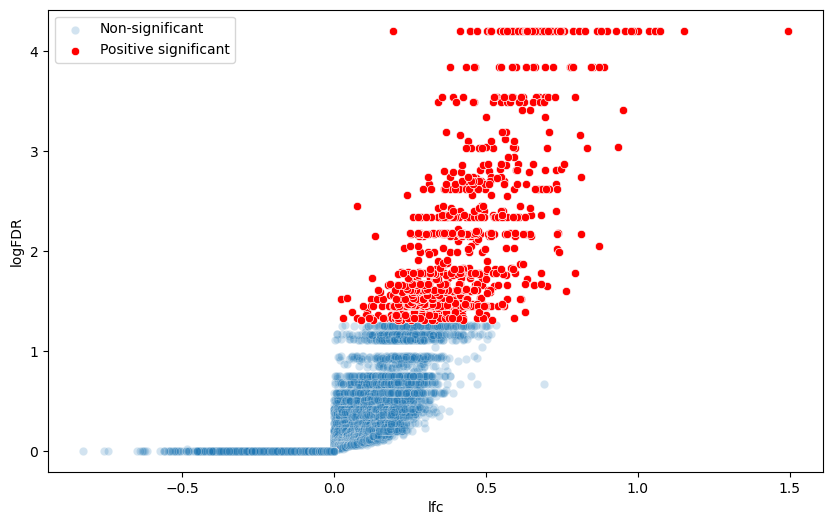

In [50]:

# Combine positive and negative data
temp = pd.concat([positive_data, negative_data])
temp['logFDR'] = -np.log10(temp['fdr'])

# Filter out rows with "hsa-" in the gene_symbol column
repooled_data = temp[~temp['gene_symbol'].str.contains("hsa-", na=False)]

# Identify significant positive and negative genes
positive_gene_label = positive_data[positive_data['fdr'] <= 0.05]['gene_symbol']
negative_gene_label = negative_data[negative_data['fdr'] <= 0.05]['gene_symbol']

# Draw volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=repooled_data, x='lfc', y='logFDR', alpha=0.2, label='Non-significant')
sns.scatterplot(data=repooled_data[repooled_data['gene_symbol'].isin(positive_gene_label)], 
                x='lfc', y='logFDR', color='red', label='Positive significant')
sns.scatterplot(data=repooled_data[repooled_data['gene_symbol'].isin(negative_gene_label)], 
                x='lfc', y='logFDR', color='blue', label='Negative significant')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


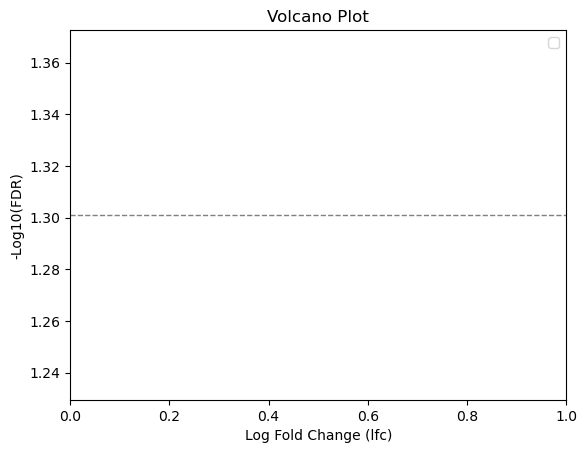

In [53]:
# Reorganize the data format
plt.axhline(-np.log10(0.05), color='gray', linestyle='--', linewidth=1)
plt.title('Volcano Plot')
plt.xlabel('Log Fold Change (lfc)')
plt.ylabel('-Log10(FDR)')
plt.legend()
plt.show()

In [61]:
normalized_counts.columns

Index(['sgRNA', 'Gene', 'DMSO1', 'DMSO2', 'DMSO3', 'palbo1', 'palbo2',
       'palbo3'],
      dtype='object')

In [66]:
normalized_counts[["DMSO1", "DMSO2", "DMSO3", "palbo1", "palbo2", "palbo3"]].corr()

,DMSO1,DMSO2,DMSO3,palbo1,palbo2,palbo3
DMSO1,1.000000,0.967730,0.974893,0.983195,0.954530,0.974712
DMSO2,0.967730,1.000000,0.958439,0.963538,0.940425,0.962419
DMSO3,0.974893,0.958439,1.000000,0.978231,0.972999,0.983226
palbo1,0.983195,0.963538,0.978231,1.000000,0.963734,0.980865
palbo2,0.954530,0.940425,0.972999,0.963734,1.000000,0.967854
palbo3,0.974712,0.962419,0.983226,0.980865,0.967854,1.000000


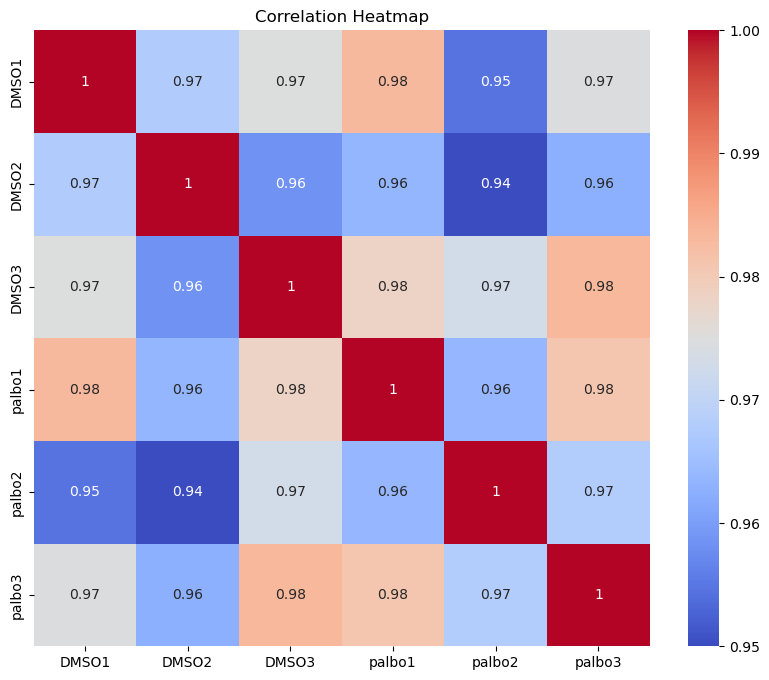

In [67]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_counts[["DMSO1", "DMSO2", "DMSO3", "palbo1", "palbo2", "palbo3"]].corr(), 
            vmin=0.95, vmax=1, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

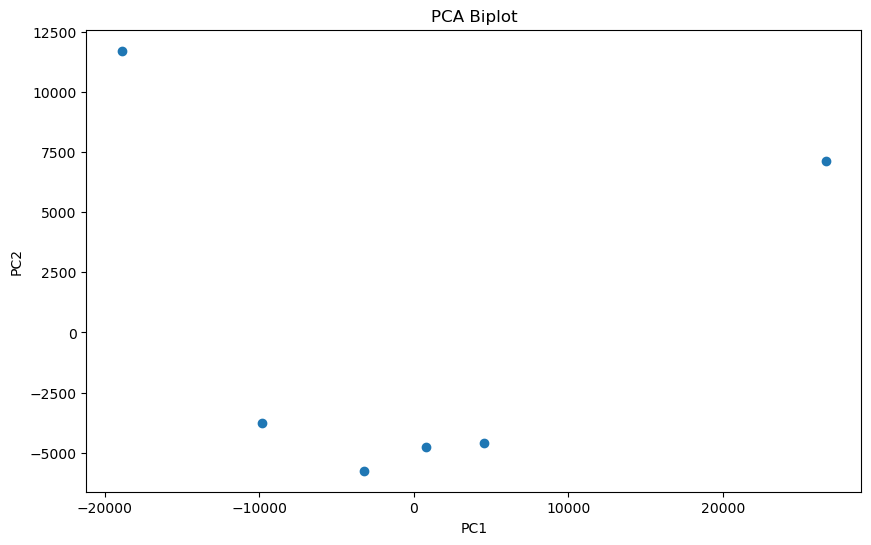

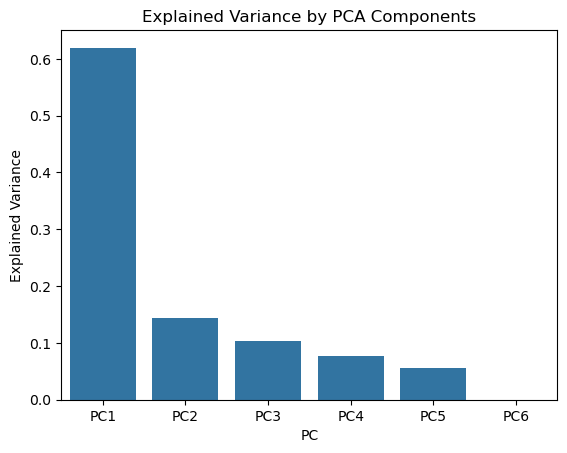

In [70]:
# PCA Analysis
pca = PCA()
pca_results = pca.fit_transform(normalized_counts[["DMSO1", "DMSO2", "DMSO3", "palbo1", "palbo2", "palbo3"]].T)

# PCA biplot
plt.figure(figsize=(10, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1])
plt.title('PCA Biplot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# PCA explained variance
pca_variance = pd.DataFrame({'PC': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
                             'Explained Variance': pca.explained_variance_ratio_})
sns.barplot(data=pca_variance, x='PC', y='Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

In [71]:
from sklearn.manifold import TSNE
import umap

# t-SNE
tsne_results = TSNE(n_components=2, random_state=42).fit_transform(normalized_counts.T)

# UMAP
umap_results = umap.UMAP(random_state=42).fit_transform(normalized_counts.T)

# Plot results
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE Visualization')
plt.show()


ModuleNotFoundError: No module named 'umap'

In [10]:
gene_summary.head()


,id,num,neg|score,neg|p-value,neg|fdr,neg|rank,neg|goodsgrna,neg|lfc,pos|score,pos|p-value,pos|fdr,pos|rank,pos|goodsgrna,pos|lfc
0,TMEM200A,3,0.000010,0.000045,0.965347,1,2,-0.48422,0.90787,0.79231,0.931361,18426,0,-0.48422
1,SLC35B2,3,0.000023,0.000111,1.000000,2,1,-0.35750,0.96729,0.92427,1.000000,19805,0,-0.35750
2,hsa-mir-1247,4,0.000040,0.000236,1.000000,3,2,-0.29045,0.94292,0.82988,0.956880,19230,0,-0.29045
3,C7orf50,3,0.000052,0.000271,1.000000,4,2,-0.61572,0.92750,0.83913,0.961716,18854,0,-0.61572
4,hsa-mir-4713,4,0.000058,0.000248,1.000000,5,3,-0.37521,0.99398,0.97771,1.000000,20459,0,-0.37521


In [2]:
# Load raw count data
raw_counts = pd.read_csv("raw_counts.csv")

# Filter gRNAs with low counts
filtered_counts = raw_counts[raw_counts['counts'] > 10]

# Normalize counts (median scaling)
filtered_counts['normalized'] = filtered_counts['counts'] / filtered_counts['counts'].median()

# Save filtered and normalized data
filtered_counts.to_csv("filtered_counts.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'raw_counts.csv'

In [52]:
from scipy.stats import ttest_ind

# Separate control and treatment samples
control = filtered_counts[filtered_counts['sample'] == 'control']['normalized']
treatment = filtered_counts[filtered_counts['sample'] == 'treatment']['normalized']

# Calculate fold changes
filtered_counts['fold_change'] = treatment.mean() / control.mean()

# Perform t-test
t_stat, p_value = ttest_ind(treatment, control)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")


NameError: name 'filtered_counts' is not defined

In [2]:
import matplotlib.pyplot as plt

# Volcano plot
plt.scatter(filtered_counts['fold_change'], -np.log10(filtered_counts['p_value']))
plt.xlabel("Fold Change")
plt.ylabel("-log10(P-Value)")
plt.title("CRISPR Screen Results")
plt.show()


NameError: name 'filtered_counts' is not defined